# 📦 Descarga de datos de precipitación desde CHIRPS

Este notebook permite descargar y preparar los datos de precipitación diaria del producto **CHIRPS (Climate Hazards Group InfraRed Precipitation with Station data)**, una fuente ampliamente utilizada para análisis climáticos.

**Fuente oficial:**  
[https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/](https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/)

CHIRPS ofrece datos de precipitación diaria desde 1981 hasta la fecha, con resolución espacial de 0.05° (~5km). Los datos se descargan en formato comprimido `.gz` y cubren todo el globo.

### 📁 Estructura de carpetas y procesamiento

Los datos descargados y procesados se almacenan en la siguiente jerarquía:

- **`raw/`**: Descarga directa de los archivos `.tif.gz` desde la fuente oficial. No se realiza ninguna modificación.
- **`interim/`**: Contiene los archivos `.tif` globales generados al descomprimir los `.gz`. Se almacenan para evitar reprocesamientos innecesarios.
- **`processed/`**: Archivos `.tif` con precipitación diaria recortada al área geográfica del Valle del Cauca (Colombia). Estos datos están listos para análisis o visualización.

---

Este notebook automatiza todo el proceso de descarga, descompresión y recorte espacial de los datos CHIRPS. Asegúrate de haber ejecutado el notebook `00_setup.ipynb` para crear las carpetas necesarias y definir los parámetros iniciales del entorno.

# 🧠 Carga de funciones del proyecto

En esta sección se importan todas las funciones necesarias que han sido previamente desarrolladas en los scripts del proyecto:

- 📥 `download.chirps`  
  Funciones de descarga y validación de datos CHIRPS.

- ☀️ `download.copernicus`  
  Funciones para descargar datos climáticos desde Copernicus (temperatura, radiación, humedad, etc.).

- 🔧 `download.utils`  
  Funciones utilitarias como:
  - Verificación de conexión a Internet
  - Validación de archivos descargados
  - Registro de logs

- 🛠 `download.process`  
  Funciones de procesamiento espacial de los datos, incluyendo:
  - `descomprimir_archivo_gz()` → descomprime archivos `.gz` en formatos `.tif` o `.nc`
  - `recortar_raster()` → recorta un raster con shapefile o bounding box

Estas funciones encapsulan toda la lógica del pipeline para mantener el notebook limpio, modular y reutilizable.


In [7]:
# Importación paquetes
import subprocess
import sys
from pathlib import Path
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date, timedelta

# Ruta base: carpeta raíz del proyecto (2 niveles arriba del notebook)
ruta_base = Path.cwd().parent.resolve()
sys.path.append(str(ruta_base))

# Confirmar que el path es correcto
print(f"Ruta base del proyecto agregada a sys.path: {ruta_base}")

# Importación de funciones de descarga y procesamiento
from download.chirps import descargar_chirps1
from download.process import descomprimir_archivo_gz, recortar_raster
from download.utils import log_event

Ruta base del proyecto agregada a sys.path: D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader


## 📍 Área de interés y configuración global de fechas

En esta sección se define la configuración **base** que será utilizada por todas las funciones de descarga a lo largo del notebook:

- **Área de interés (AOI)**:  
  Se carga el shapefile del departamento **Valle del Cauca**, ubicado en `data/auxiliary/shapefiles/valle/valle.shp`.  


- **Rango de fechas**:  
  Se establece un rango temporal definido por `fecha_inicio` y `fecha_fin`, con un intervalo diario.  
  Este rango será reutilizado para construir las fechas de descarga para **CHIRPS**.




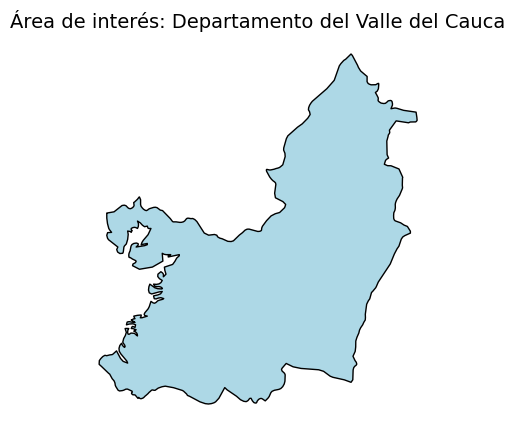

📅 Fecha de inicio de descarga: 2010-01-01
📅 Fecha de fin de descarga:    2010-01-02


In [ ]:
# 📍 Cargar shapefile del Valle del Cauca
shapefile_valle = ruta_base / "data" / "auxiliary" / "shapefiles" / "valle" / "valle.shp"
gdf_valle = gpd.read_file(shapefile_valle)

# 🗺️ Visualizar el área de interés
fig, ax = plt.subplots(figsize=(5, 5))
gdf_valle.plot(ax=ax, color='lightblue', edgecolor='black')
ax.set_title("Área de interés: Departamento del Valle del Cauca", fontsize=14)
ax.set_axis_off()
plt.show()

# 📆 Rango de fechas de descarga
fecha_inicio = date(2013, 6, 1)
fecha_fin = date(2013, 6, 15)

print(f"📅 Fecha de inicio de descarga: {fecha_inicio.strftime('%Y-%m-%d')}")
print(f"📅 Fecha de fin de descarga:    {fecha_fin.strftime('%Y-%m-%d')}")


# 🌧️ Proceso de descarga CHIRPS

En esta sección se realiza la descarga de datos de precipitación del dataset **CHIRPS** (Climate Hazards Group InfraRed Precipitation with Station data).

CHIRPS proporciona datos satelitales de precipitación diarios con cobertura global, ideales para estudios climáticos y agrícolas.

### 🧩 Detalles del flujo:

- Se define un rango de fechas deseado.
- Se construye automáticamente la URL de descarga para cada archivo `.tif.gz`
- Se descarga cada archivo en la carpeta `data/raw/chirps/`
- Luego se descomprime y se guardad en la carpeta `data/interim/chirps/` 
- El resultado recortado se guarda en `data/processed/chirps/`

El proceso incluye verificación de archivos, control de errores, conexión a Internet y logs de eventos.

In [9]:
delta = timedelta(days=1)
fecha = fecha_inicio


# Definir rutas útiles para todo el notebook
RAW_CHIRPS = ruta_base / "data" / "raw" / "chirps"
INTERIM_CHIRPS = ruta_base / "data" / "interim" / "chirps"
PROCESSED_CHIRPS = ruta_base / "data" / "processed" / "chirps"

while fecha <= fecha_fin:
    anio = fecha.year
    fecha_str = fecha.strftime("%Y-%m-%d")
    nombre_archivo = f"chirps-v2.0.{fecha_str.replace('-', '.')}.tif.gz"

    url = f"https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/tifs/p05/{anio}/{nombre_archivo}"
    ruta_gz = RAW_CHIRPS / nombre_archivo
    ruta_tif = INTERIM_CHIRPS / nombre_archivo.replace(".gz", "")
    ruta_clip = PROCESSED_CHIRPS / f"valle_{fecha_str}.tif"

    try:
        print(f"\n📅 Fecha: {fecha_str}")
        print(f"⬇️ URL: {url}")
        print(f"📥 RAW:        {ruta_gz}")
        print(f"🗜️ INTERIM:   {ruta_tif}")
        print(f"📦 PROCESSED:    {ruta_clip}")

        # Paso 1: Descargar
        descargar_chirps1(url, ruta_gz)

        # Paso 2: Descomprimir
        descomprimir_archivo_gz(ruta_gz, ruta_tif)

        # Paso 3: Recortar
        recortar_raster(
            ruta_raster=ruta_tif,
            ruta_salida=ruta_clip,
            ruta_shapefile=shapefile_valle
        )
        
    except Exception as e:
        print(f"❌ Error en la fecha {fecha_str}: {e}")

    fecha += delta


📅 Fecha: 2010-01-01
⬇️ URL: https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/tifs/p05/2010/chirps-v2.0.2010.01.01.tif.gz
📥 RAW:        D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\raw\chirps\chirps-v2.0.2010.01.01.tif.gz
🗜️ INTERIM:   D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\interim\chirps\chirps-v2.0.2010.01.01.tif
📦 PROCESSED:    D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\processed\chirps\valle_2010-01-01.tif


Descargando chirps-v2.0.2010.01.01.tif.gz: 100%|██████████| 3.63M/3.63M [00:01<00:00, 3.15MB/s]


✓ Descarga correcta: chirps-v2.0.2010.01.01.tif.gz
Descomprimido: D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\interim\chirps\chirps-v2.0.2010.01.01.tif
Raster recortado guardado en: D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\processed\chirps\valle_2010-01-01.tif

📅 Fecha: 2010-01-02
⬇️ URL: https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/tifs/p05/2010/chirps-v2.0.2010.01.02.tif.gz
📥 RAW:        D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\raw\chirps\chirps-v2.0.2010.01.02.tif.gz
🗜️ INTERIM:   D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\interim\chirps\chirps-v2.0.2010.01.02.tif
📦 PROCESSED:    D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\processed\chirps\valle_2010-01-02.tif


Descargando chirps-v2.0.2010.01.02.tif.gz: 100%|██████████| 3.76M/3.76M [00:01<00:00, 3.16MB/s]


✓ Descarga correcta: chirps-v2.0.2010.01.02.tif.gz
Descomprimido: D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\interim\chirps\chirps-v2.0.2010.01.02.tif
Raster recortado guardado en: D:\OneDrive - CGIAR\Desktop\codigos_dengue\climate_data_downloader\data\processed\chirps\valle_2010-01-02.tif
